In [13]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

Pkg.add("MathOptInterface")
Pkg.add("Ipopt")
Pkg.add("ForwardDiff")
Pkg.add("FiniteDiff")
Pkg.add("Convex") 
Pkg.add("ECOS")
Pkg.add("JLD2")
Pkg.add("Plots")


import MathOptInterface as MOI
import Ipopt 
import FiniteDiff
import ForwardDiff
import Convex as cvx 
import ECOS
using LinearAlgebra
using Plots
using Random
using JLD2
using Test
import MeshCat as mc 

  Activating environment at `~/tiltrotor_control/Project.toml`


   Resolving package versions...


  No Changes to `~/tiltrotor_control/Project.toml`
  No Changes to `~/tiltrotor_control/Manifest.toml`


   Resolving package versions...


  No Changes to `~/tiltrotor_control/Project.toml`
  No Changes to `~/tiltrotor_control/Manifest.toml`


   Resolving package versions...


  No Changes to `~/tiltrotor_control/Project.toml`
  No Changes to `~/tiltrotor_control/Manifest.toml`


   Resolving package versions...


  No Changes to `~/tiltrotor_control/Project.toml`
  No Changes to `~/tiltrotor_control/Manifest.toml`


   Resolving package versions...


  No Changes to `~/tiltrotor_control/Project.toml`
  No Changes to `~/tiltrotor_control/Manifest.toml`


   Resolving package versions...


  No Changes to `~/tiltrotor_control/Project.toml`
  No Changes to `~/tiltrotor_control/Manifest.toml`


   Resolving package versions...


  No Changes to `~/tiltrotor_control/Project.toml`
  No Changes to `~/tiltrotor_control/Manifest.toml`


   Resolving package versions...


  No Changes to `~/tiltrotor_control/Project.toml`
  No Changes to `~/tiltrotor_control/Manifest.toml`


In [22]:
include(joinpath(@__DIR__, "utils", "fmincon.jl"))
include(joinpath(@__DIR__, "utils", "tiltrotor_dynamics.jl"))

hermite_simpson (generic function with 2 methods)

## Direct Collocation (DIRCOL) for Tiltrotor



In [23]:
function create_idx(nx,nu,N)
    # This function creates some useful indexing tools for Z 
    # x_i = Z[idx.x[i]]
    # u_i = Z[idx.u[i]]   
    
    # our Z vector is [x0, u0, x1, u1, …, xN]
    nz = (N-1) * nu + N * nx # length of Z 
    x = [(i - 1) * (nx + nu) .+ (1 : nx) for i = 1:N]
    u = [(i - 1) * (nx + nu) .+ ((nx + 1):(nx + nu)) for i = 1:(N - 1)]
    
    # constraint indexing for the (N-1) dynamics constraints when stacked up
    c = [(i - 1) * (nx) .+ (1 : nx) for i = 1:(N - 1)]
    nc = (N - 1) * nx # (N-1)*nx 
    
    return (nx=nx,nu=nu,N=N,nz=nz,nc=nc,x= x,u = u,c = c)
end

function trajectory_cost(params::NamedTuple, Z::Vector)::Real
    idx, N, xg = params.idx, params.N, params.xg
    Q, R, Qf = params.Q, params.R, params.Qf
    
    J = 0 
    for i = 1:(N-1)
        xi = Z[idx.x[i]]
        ui = Z[idx.u[i]]
        
        J += 0.5*(xi - xg)'*Q*(xi - xg) + 0.5*ui'*R*ui
    end
    
    # dont forget terminal cost 
    J += 0.5*(Z[idx.x[N]] - xg)'*Qf*(Z[idx.x[N]] - xg)
    
    return J 
end

function dynamics_constraints(params::NamedTuple, Z::Vector)::Vector
    idx, N, dt = params.idx, params.N, params.model.dt

    c = zeros(eltype(Z), idx.nc)
    
    for i = 1:(N-1)
        xi = Z[idx.x[i]]
        ui = Z[idx.u[i]] 
        xip1 = Z[idx.x[i+1]]
        
        c[idx.c[i]] = hermite_simpson(params.model, tiltrotor_dynamics_mrp, xi, xip1, ui, dt)
    end
    return c 
end

function equality_constraint(params::NamedTuple, Z::Vector)::Vector
    N, idx, xic, xg = params.N, params.idx, params.xic, params.xg 
    
    # c = [dynamics constraints, initial state constraint, goal state constraint]

    c = zeros(eltype(Z), idx.nc + 2*idx.nx)
    c[1:idx.nc] = dynamics_constraints(params, Z)
    c[idx.nc+1:idx.nc+idx.nx] = Z[idx.x[1]] - xic
    c[idx.nc+idx.nx+1:idx.nc+2*idx.nx] = Z[idx.x[N]] - xg
        
    return c
end

function solve_tiltrotor_trajectory(;verbose=true)
    
    # problem size 
    nx = 14
    nu = 4
    dt = 0.05
    tf = 2.0 
    t_vec = 0:dt:tf 
    N = length(t_vec)
    
    # LQR cost 
    Q = diagm(ones(nx))
    R = 0.1*diagm(ones(nu))
    Qf = 10*diagm(ones(nx))
    
    # indexing 
    idx = create_idx(nx,nu,N)
    
    # initial and goal states 
    xic = zeros(14)
    xg = zeros(14)
    xg[3] = 1.0

    # dynamics parameters (these are estimated)
    model = (
        mass=0.5,
        J=Diagonal([0.0023, 0.0023, 0.004]),
        gravity=[0,0,-9.81],
        L=0.1750,
        kf=1.0,
        km=0.0245,
        kδ=1.0,
        S_wing=0.05,
        ρ = 1.225,
        dt = dt
        )

    # the params needed by DIRCOL 
    params = (
        N = N, 
        idx = idx,
        xic = xic,
        xg = xg,
        Q = Q, 
        R = R, 
        Qf = Qf, 
        model = model
    )
              
    # primal bounds 
    x_l = -Inf*ones(idx.nz)
    x_u = Inf*ones(idx.nz)
    
    # inequality constraint bounds (we have no inequality constraints)
    c_l = zeros(0)
    c_u = zeros(0)
    function inequality_constraint(params, Z)
        return zeros(eltype(Z), 0)
    end
    
    # initial guess 
    z0 = zeros(idx.nz)
    uhover = ((9.81*model.mass/2)/model.kf)*ones(4)
    uhover[3] = 0.0
    uhover[4] = 0.0
    for i = 1:N-1
        z0[idx.x[i]] = [0;0;i/N;zeros(11)]
        z0[idx.u[i]] = uhover
    end
    z0[idx.x[N]] = [0;0;1;zeros(11)]
    
    # choose diff type (try :auto, then use :finite if :auto doesn't work)
    diff_type = :auto 
    # diff_type = :finite
    
    Z = fmincon(trajectory_cost,equality_constraint,inequality_constraint,
                x_l,x_u,c_l,c_u,z0,params, diff_type;
                tol = 1e-6, c_tol = 1e-6, max_iters = 10_000, verbose = verbose)
    
    # pull the X and U solutions out of Z 
    X = [Z[idx.x[i]] for i = 1:N]
    U = [Z[idx.u[i]] for i = 1:(N-1)]
    
    return X, U, t_vec, params 
end

solve_tiltrotor_trajectory (generic function with 1 method)

---------checking dimensions of everything----------
---------all dimensions good------------------------
---------diff type set to :auto (ForwardDiff.jl)----
---------testing objective gradient-----------------


---------testing constraint Jacobian----------------


---------successfully compiled both derivatives-----


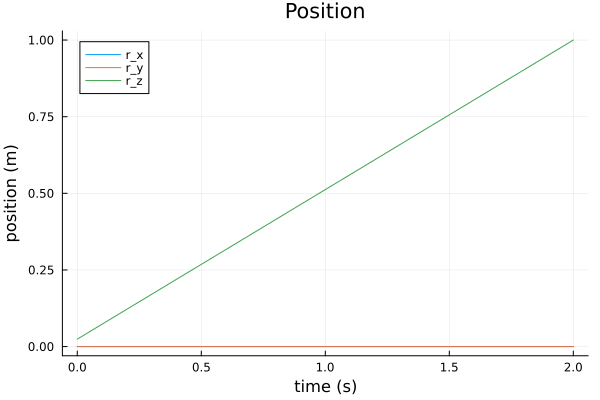

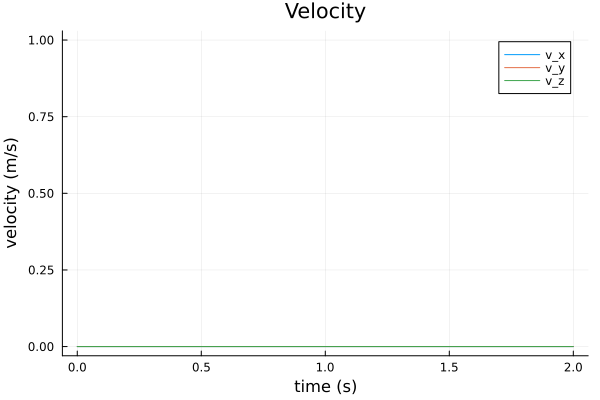

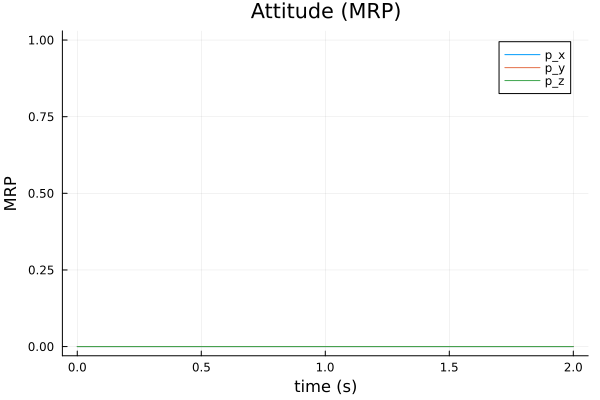

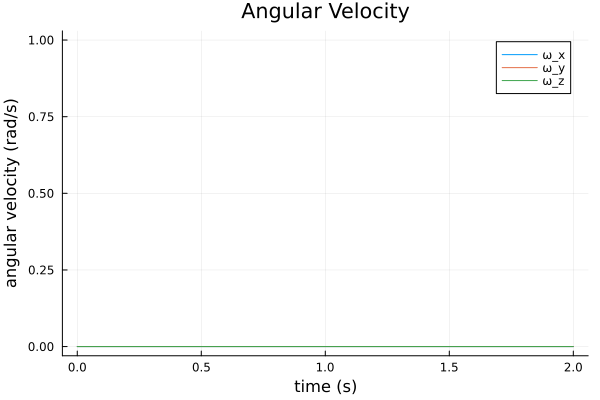

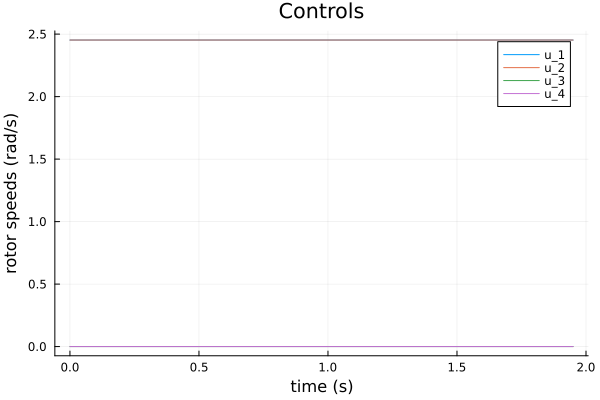

---------IPOPT beginning solve----------------------



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   431592
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

The Jacobian for the equality constraints contains an invalid number

Number of Iterations....: 0

Number of objective function evaluations             = 0
Number of objective gradient evaluations             = 0
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality con

In [24]:
X, U, t_vec = solve_tiltrotor_trajectory(verbose=true)

Xm = hcat(X...)
Um = hcat(U...)

# --------------plotting-----------------
display(plot(t_vec, Xm[1:3,:]', xlabel = "time (s)", ylabel = "position (m)",
                                title = "Position", label = ["r_x" "r_y" "r_z"]))
display(plot(t_vec, Xm[4:6,:]', xlabel = "time (s)", ylabel = "velocity (m/s)",
                                title = "Velocity", label = ["v_x" "v_y" "v_z"]))
display(plot(t_vec, Xm[7:9,:]', xlabel = "time (s)", ylabel = "MRP",
                                title = "Attitude (MRP)", label = ["p_x" "p_y" "p_z"]))
display(plot(t_vec, Xm[10:12,:]', xlabel = "time (s)", ylabel = "angular velocity (rad/s)",
                                title = "Angular Velocity", label = ["ω_x" "ω_y" "ω_z"]))
display(plot(t_vec[1:end-1], Um', xlabel = "time (s)", ylabel = "rotor speeds (rad/s)",
                                title = "Controls", label = ["u_1" "u_2" "u_3" "u_4"]))